# The Haunted DAG and Causal Terror

In [24]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
# R-like interface, alternatively you can import statsmodels as import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

## Multicollinearity

It is commonly true that there are many potential predictor variables to add to a regression model. In the case of the primate milk data, for example, there are 7 variables available to predict any column we chose as an outcome. Why not just fit a model that includes all 7? There are several hazards. The one we'll focus on here is MULTICOLLINEARITY. Multicollinearity means very strong correlation between two or more predictor variables. The consequence of it is that the posterior distribution will seem to suggest that none of the variables is reliably associated with the outcome, even if all of the variables are in reality strongly associated with the outcome. This frustrating phenomonon arises from the details of how multiple regression works. In fact, there is nothing wrong with multicollinearity. The model will work fine for prediction. You will just be frustrated trying to understand it. The hope is that once you understand multicollinearity, you will better understand regression models in general.

### Multicollinear legs

The code below will simulate the heights and leg lengths of 100 individuals. For each first a height is simulated from a gaussian distribution. Then each individual gets a simulated proportion of height for their legs, ranging from 0.4 to 0.5. Finally each measurement is salted with a little measurement or developmental error, so the left and right legs are not exactly the same length, so it typical in real populations.

In [4]:
N = 100
height = stats.norm.rvs(size=N, loc=10, scale=2)
leg_prop = stats.uniform.rvs(size=N, loc=0.4, scale=0.1)   # remember loc and scale have been repurposed to min and max 
leg_left = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
leg_right = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)

df = pd.DataFrame({'height': height,
                   'leg_left': leg_left,
                   'leg_right': leg_right})

df.head()

,height,leg_left,leg_right
0,8.820874,3.941342,3.889197
1,7.893202,3.467567,3.459874
2,14.343867,6.142550,6.195568
3,12.075518,5.523269,5.493964
4,8.345456,3.913639,3.900918


Now lets analyse the data, predicting the outcome 'height' with both predictors, leg_left and leg_right. Before approximating the posterior, however consider what we expect. On average, an individuals legs are 45% of their height. So we should expect the beta coefficient that measures the association of a leg with height to end up around the average height (10) divided by 45%. This is 10/4.5 = 2.2. Now lets see what happens instead. (using very vague priors)

In [5]:
with pm.Model() as m6_1:
    a = pm.Normal('a', mu=10, sd=100)
    bl = pm.Normal('bl', mu=2, sd=10)
    br = pm.Normal('br', mu=2, sd=10)
    mu = pm.Deterministic('mu', a + bl * leg_left + br * leg_right)    
    sigma = pm.Exponential('sigma', lam=1)
    height_p = pm.Normal('height_p', mu=mu, sd=sigma, observed=height)
    
    trace_6_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, br, bl, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [01:39<00:00, 80.52draws/s] 


In [7]:
pm.summary(trace_6_1,['a','bl','br'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.841,0.307,0.245,1.398,0.006,0.004,2557.0,2548.0,2563.0,1908.0,1.0
bl,-0.286,2.132,-4.363,3.555,0.057,0.044,1421.0,1196.0,1420.0,1554.0,1.0
br,2.318,2.136,-1.553,6.381,0.057,0.041,1421.0,1368.0,1421.0,1573.0,1.0


array([<AxesSubplot:title={'center':'94.0% Credible Interval'}>],
      dtype=object)

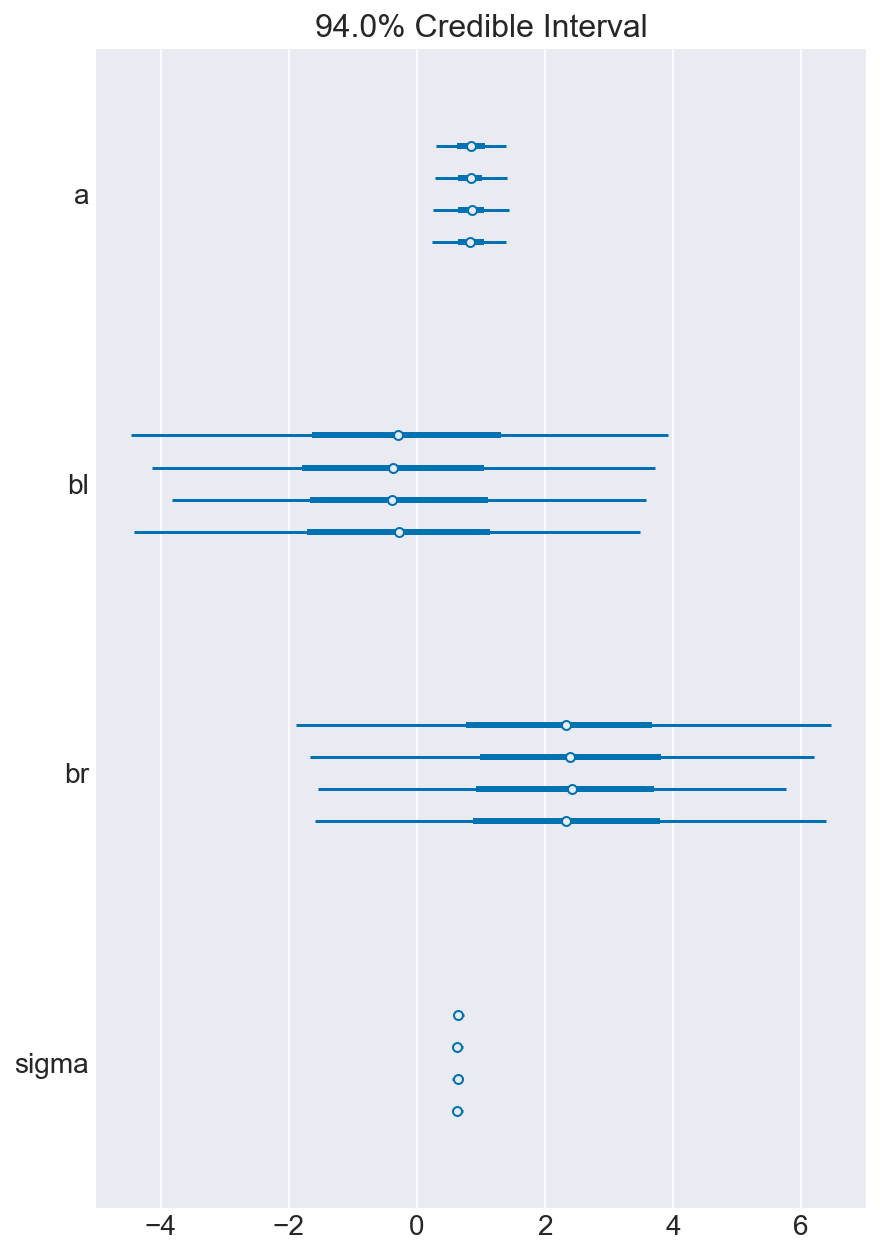

In [9]:
pm.plot_forest(trace_6_1, var_names = ['a','bl','br','sigma'])

Those posterior means and standard deviations look crazy. Did the model work correctly? - yes - The posterior distribution is the right answer to the question we asked. The problem is the question. Recall that a multiple linear regression answers the question:

*What is the value of knowing each predictor, after already knowing all of the other predictors?*

So in this case, the question becomes: *what is the value of knowing each legs length, after already knowing the other legs length*

The answer to this wierd question is equally wierd, but perfectly logical. The posterior distribution is the answer to this question, considering every possible combination of the parameters and assigning relative plausabilities to every combination, conditional on this model and these data. It may help to look at the bivariate posterior distribution for bl and br

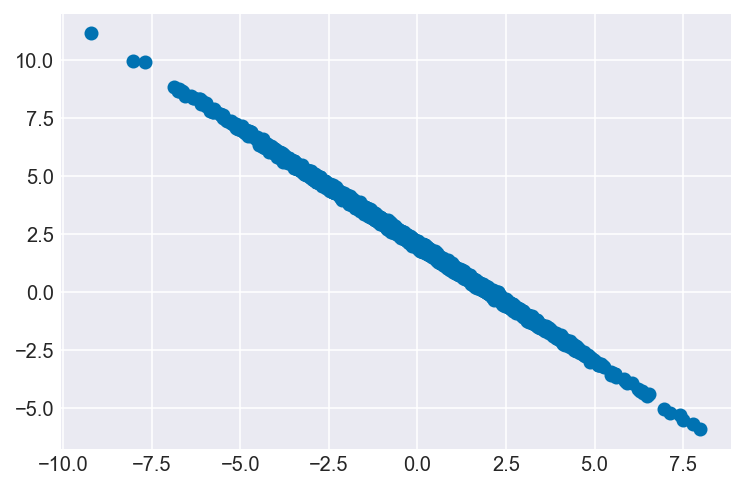

In [10]:
plt.scatter(trace_6_1['bl'], trace_6_1['br'])

(array([  27.,  117.,  395.,  742., 1016.,  918.,  506.,  205.,   56.,
          18.]),
 array([1.82543543, 1.86936778, 1.91330012, 1.95723247, 2.00116481,
        2.04509716, 2.0890295 , 2.13296185, 2.17689419, 2.22082654,
        2.26475888]),
 <BarContainer object of 10 artists>)

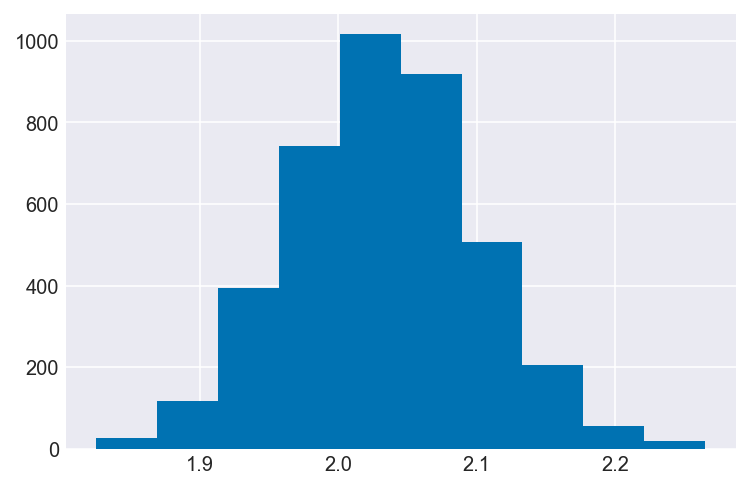

In [11]:
plt.hist(trace_6_1['bl']+ trace_6_1['br'])

The resulting plot above. The posterior distribution for these two parameters is very highly correlated, with all of the plausible values of bl and br laying along a narrow ridge. When bl is large, then br must be small. What has happened here is that since both leg variables contain almost exactly the same information, if you insist on including both in a model, then there will be practically an infinite number of combinations of bl and br that produce the same predictions.

When two predictor variables are very strongly correlated, including both in a model may lead to confusion. The posterior distribution isnt wrong in such cases. Its telling you that the question you asked cannot be answered with these data. And thats a great thing for a model to say, that it cannot answer your question. And if you are just interested in prediction, you'll find that this leg model makes fine predictions. It just doesnt make any claims about which leg is important.

## Multicollinear Milk

In the leg length example, its easy to see that including both legs in the model is a little silly. But the problem arises in real data sets is that we may not anticipate a clash between highly correlated predictors. And therefore we may mistakenly read the posterior distribution to say that neither predictor is important. 

Lets return to the primate milk data from earlier:

In [15]:
def standardise(data):
    return (data-data.mean())/data.std()

milk_df = pd.read_csv('milk.csv', sep=';')
#milk_df.dropna(inplace=True)

milk_df['K'] = standardise(milk_df['kcal.per.g'])
milk_df['F'] = standardise(milk_df['perc.fat'])
milk_df['L'] = standardise(milk_df['perc.lactose'])
milk_df.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,F,L
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-1.217243,1.307262
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,-1.030355,1.011285
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,-1.391531,1.382679
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,-1.335535,1.586874
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,-0.469693,0.257115


In [19]:
with pm.Model() as m6_3:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk_df['F'])    
    sigma = pm.Exponential('sigma', lam=1)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk_df['K'])
    trace_6_3 = pm.sample(1000, tune=1000)
    
pm.summary(trace_6_3,['a','bf','sigma'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bf, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1691.17draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.000,0.094,-0.174,0.176,0.001,0.002,4046.0,1352.0,4236.0,2711.0,1.0
bf,0.879,0.094,0.698,1.054,0.002,0.001,3783.0,3783.0,3782.0,3015.0,1.0
sigma,0.489,0.071,0.372,0.623,0.001,0.001,3721.0,3563.0,3833.0,2711.0,1.0


In [21]:
with pm.Model() as m6_4:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bl= pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bl * milk_df['L'])    
    sigma = pm.Exponential('sigma', lam=1)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk_df['K'])
    trace_6_3 = pm.sample(1000, tune=1000)
    
pm.summary(trace_6_3,['a','bl','sigma'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bl, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1697.62draws/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.077,-0.140,0.148,0.001,0.001,4464.0,2138.0,4494.0,2791.0,1.0
bl,-0.916,0.080,-1.063,-0.763,0.001,0.001,4735.0,4653.0,4768.0,2471.0,1.0
sigma,0.412,0.059,0.311,0.525,0.001,0.001,3604.0,3409.0,3865.0,3082.0,1.0


The posterior distributions for bF and bL are essentially mirror images of one another. The posterior mean of bF is as positive as the mean of BL is negative. Both are narrow posterior distributions that lie almost entirely on one side or the other of zero. Given the strong association of each predictor with the outcome, we might conclude that both variables are reliable predictors of total energy in milk, across species. The more fat, the more kilocalories in the milk. The more lactose, the fewer kilocalories in milk. But watch what happens when we place both predictor variables in the same regression model.

In [22]:
with pm.Model() as m6_5:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bl= pm.Normal('bl',mu=0, sd= 1)
    bf = pm.Normal('bf',mu=0, sd= 1)
    
    mu = pm.Deterministic('mu',a + bl * milk_df['L'] + bf * milk_df['F'])    
    sigma = pm.Exponential('sigma', lam=1)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk_df['K'])
    trace_6_3 = pm.sample(1000, tune=1000)
    
pm.summary(trace_6_3,['a','bl','bf','sigma'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bf, bl, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:09<00:00, 812.41draws/s] 
The acceptance probability does not match the target. It is 0.8795979059250331, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.000,0.080,-0.158,0.148,0.002,0.002,2339.0,1349.0,2439.0,1904.0,1.0
bl,-0.724,0.230,-1.166,-0.294,0.006,0.004,1682.0,1597.0,1685.0,1904.0,1.0
bf,0.205,0.230,-0.243,0.631,0.006,0.004,1642.0,1642.0,1640.0,1835.0,1.0
sigma,0.416,0.061,0.310,0.529,0.001,0.001,1882.0,1872.0,1883.0,1953.0,1.0


Now the posterior means of both bF and bL are closer to zero. And the standard deviations for both are twice as large as in the bivariate models. This is the same statistical phenomenon as in the leg length example. What has happened is that the variables 'fat' and 'lactose' contain much of the same information. They are almost substitutes for one another. As a results when you include both in a regression, the posterior distribution ends up describing a long ridge of combinations of bF and bL that are equally plausibe.

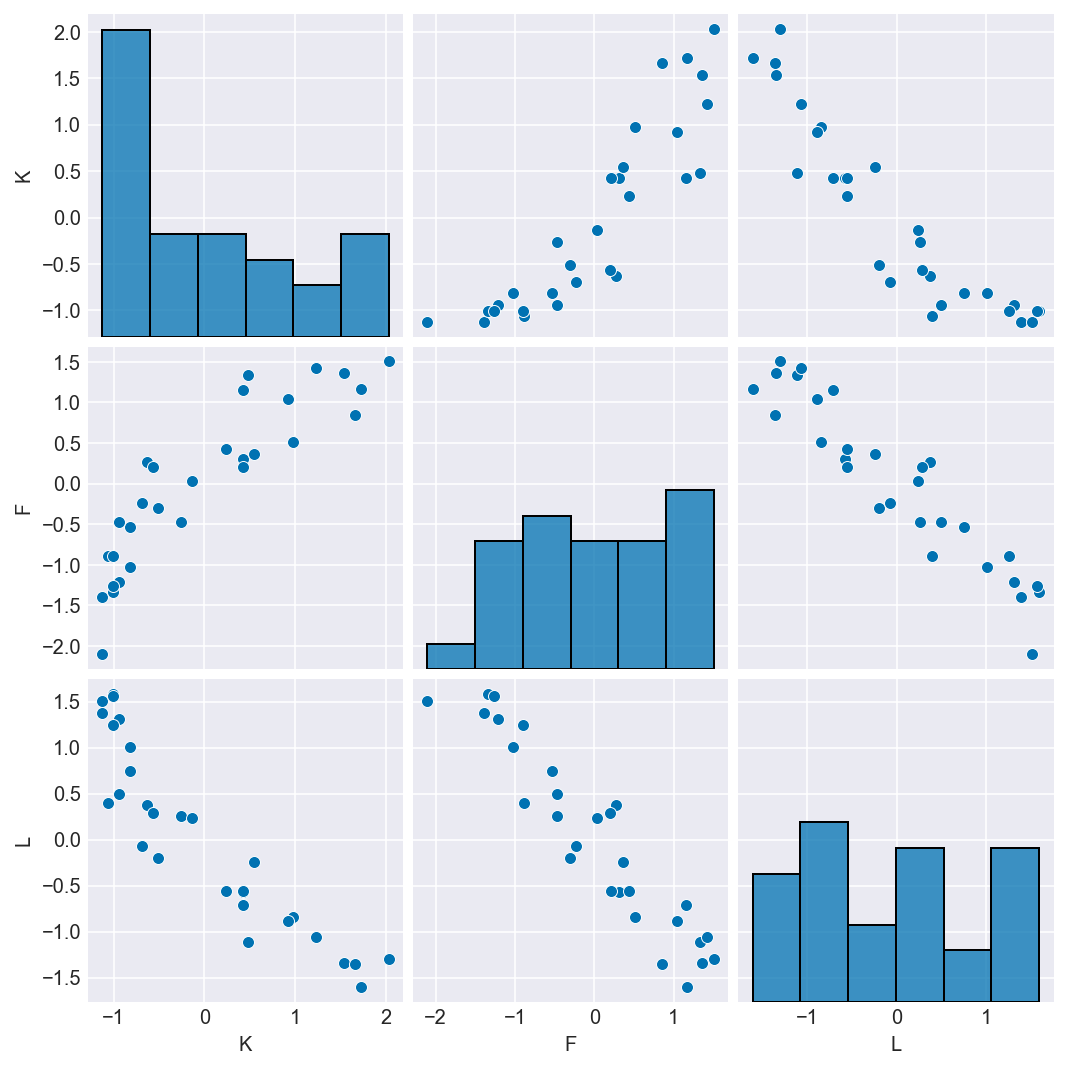

In [26]:
sns.pairplot(milk_df[['K','F','L']])

In the scientific literature, you might encounter a variety of dodgy ways of coping with multicollinearity. Few of them take a causal perspective. Some fields actually teach students to inspect pairwise correlations before fitting a model, to identify and drop highly correlated predictors. This is a mistake. Pairwise correlations are not the problem. It is the conditional associations - not correlations - that matter. And even then, the right thing to do will depend on what is causing the collinearity. The associations within the data along are not enough to decide what to do.

Whats going on in the milk example is that there is a core tradeoff in milk composition that mammel mothers must obey. If a species nurses often, then the milk tends to be watery and low in energy. Such milk is high is sugar (lactose). If instead a species nurses rarely, in short bouts, then the milk needs to be higher in energy. such milk is very high in fat.

This implies there is an unseen variable - Density

The problem of multicollinearilty is a member of a family of problems with fitting models, a family sometimes knows as non-identifiability. When a parameter is non-identifyable, it means that the structure of the data and the model do not make it possible to estimate the parameters value.

In general, there is no guarantee that the available data contain much information about a parameter of interest. When thats true, your bayesian machine will return a posterior very similar to the prior. Comparing the posterior to the prior can therefore be a good idea, a way of seeing how much information the model extracted from the data.